In [11]:
import requests
import joblib
import datetime
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from pandas import option_context
from tqdm import tqdm
from statsmodels.stats.inter_rater import aggregate_raters
from sklearn.metrics import cohen_kappa_score
from scipy.stats import mannwhitneyu,shapiro,ttest_ind

import cliffsDelta as cd
import GenerateActivities as gat
import important_features as imf

In [ ]:
QUERY_ROOT = "https://api.github.com"
TOKEN = '' # write your GitHub API key here
HEADERS={'Authorization':'token '+TOKEN}

## Section 3

### Question 1

#### Write an automated Python script to identify all GitHub bot actors in the list of contributors, by querying the GitHub REST API users endpoint and extracting the required information to make this decision. 

#### More information: You can search for the "type" key in the obtianed JSON result, If it is "Bot", then it is a bot actor, if it is "User", then it is an account.

In [12]:
import pandas as pd

# Load the CSV file (replace 'sample.csv' with the actual filename)
df = pd.read_csv("Contributors/sample26.csv")

# Ensure the required columns are present
required_columns = ["contributor", "bothunter_type"]
assert all(col in df.columns for col in required_columns), "Missing required columns!"

# Display the first few rows of the DataFrame
print(df.head())


           contributor bothunter_type
0             DaniGlez          Human
1  JosephBARBIERDARNAL          Human
2           Peter-Hogg          Human
3          SunyongKwon          Human
4          adrinjalali          Human


In [13]:
# Extract contributor names into a list
contributors_list = df["contributor"].tolist()

# Print the list of contributors
print(contributors_list)


['DaniGlez', 'JosephBARBIERDARNAL', 'Peter-Hogg', 'SunyongKwon', 'adrinjalali', 'araujoms', 'bgruening', 'chainsawriot', 'dask-bot', 'davidbrochart', 'ericphanson', 'github-actions[bot]', 'github-advanced-security[bot]', 'gnikit', 'gxydevbot', 'hackmd-hub[bot]', 'ilayn', 'jessegrabowski', 'juanis2112', 'kratman', 'kwrobot', 'lumberbot-app[bot]', 'm-albert', 'mbauman', 'mirror-dump', 'mrclary', 'napari-bot', 'nsoranzo', 'pep8speaks', 'petrasovaa', 'review-notebook-app[bot]', 'ricardoV94', 'rodoulak', 'scikit-learn-bot', 'sebastian-luna-valero', 'tarleb', 'transifex-integration[bot]', 'vchuravy', 'welcome[bot]', 'zachary-foster']


In [14]:
# 1. Using a for loop, iterate over each contributor in the list and query the GitHub Users API.
#    You can use "query = f'{QUERY_ROOT}/users/{contributor}'", where QUERY_ROOT is defined at the beginning of this notebook 
#    and 'contributor' is each individual contributor from the list
# 2. Get the response using 'response = requests.get(query, headers=HEADERS)'.
# 3. convert the response to JSON using 'json_response = response.json()'.
# 4. Iterate over each JSON response and get the value of the 'type' key. If it is "Bot" then the contributor is a bot actor, 
#    if "User" then the contributor is an account. You should boolean values to indicate if the contributor is a bot actor (True) or User/Organisation (False)
# 5. Save these results in list of dictionary of the form [{'contributor': <contributor name>, 'app': <boolean value>}, {...}, {...}, {...}].
#    Lets call this list as "app_dict"
# 6. Finally convert this list of dictionary to DataFrame by writing 'pd.DataFrame.from_dict(app_dict)'
# 7. Display the DataFrame. This should have two columns - contributor and app

import requests
import pandas as pd

# GitHub API details
QUERY_ROOT = "https://api.github.com"
HEADERS = {"Authorization": f"token {TOKEN}"}

# List to store results
app_dict = []

# Loop through each contributor and query GitHub API
for contributor in contributors_list:
    query = f"{QUERY_ROOT}/users/{contributor}"
    response = requests.get(query, headers=HEADERS)

    if response.status_code == 200:  # Check if request was successful
        json_response = response.json()
        is_bot = json_response.get("type") == "Bot"  # True if bot, False otherwise
        app_dict.append({"contributor": contributor, "app": is_bot})
    else:
        print(f"Error fetching data for {contributor}: {response.status_code}")

# Convert the list of dictionaries to a DataFrame
app_df = pd.DataFrame.from_dict(app_dict)

# Display the DataFrame
print(app_df.head())


           contributor    app
0             DaniGlez  False
1  JosephBARBIERDARNAL  False
2           Peter-Hogg  False
3          SunyongKwon  False
4          adrinjalali  False


### Question 2

#### Add a new 'actor' column in the CSV file to store this information. You can write True if it is a bot actor and False if it is not.

#### Report on the total number of GitHub bot actors, and User accounts present in the list of accounts of your dataset.

In [15]:
# Merge the app DataFrame to df by writing 'pd.merge(df, <app df>, on='contributor'). This is similar to SQL join on primary key 'contributor'.
# The resultant df should have 3 columns - contributor, bothunter_type and user_type.

# Merge the app DataFrame with the original df on 'contributor'
df = pd.merge(df, app_df, on="contributor")

# Rename 'app' column to 'actor' for clarity
df.rename(columns={"app": "actor"}, inplace=True)

# Count the total number of bots and users
num_bots = df["actor"].sum()  # True counts as 1, summing gives the bot count
num_users = len(df) - num_bots

# Display results
print(f"Total GitHub Bot Actors: {num_bots}")
print(f"Total GitHub User Accounts: {num_users}")

# Display the updated DataFrame
print(df.head())

# Save the updated DataFrame to a CSV file
df.to_csv("updated_contributors.csv", index=False)


Total GitHub Bot Actors: 7
Total GitHub User Accounts: 33
           contributor bothunter_type  actor
0             DaniGlez          Human  False
1  JosephBARBIERDARNAL          Human  False
2           Peter-Hogg          Human  False
3          SunyongKwon          Human  False
4          adrinjalali          Human  False


### Question 3

#### For each bot actor, write their purpose, the task that they automate by looking at their GitHub profile, homepage, information on the GitHub Marketplace, or other documentation that you can find online.


In [16]:
# Filter only bot actors
bot_actors = df[df["actor"] == True]["contributor"].tolist()

# Function to get bot descriptions from GitHub API
def get_bot_purpose(bot_name):
    query = f"https://api.github.com/users/{bot_name}"
    response = requests.get(query, headers=HEADERS)
    
    if response.status_code == 200:
        json_response = response.json()
        return json_response.get("bio", "No description available")  # Fetch bot description
    return "Error fetching data"

# Create a dictionary storing bot names and their purposes
bot_purposes = {bot: get_bot_purpose(bot) for bot in bot_actors}

# Convert to DataFrame
bot_df = pd.DataFrame(list(bot_purposes.items()), columns=["Bot Name", "Purpose"])

# Display the bot purposes
print(bot_df)

# Save the results
bot_df.to_csv("bot_purposes.csv", index=False)


                        Bot Name Purpose
0            github-actions[bot]    None
1  github-advanced-security[bot]    None
2                hackmd-hub[bot]    None
3             lumberbot-app[bot]    None
4       review-notebook-app[bot]    None
5     transifex-integration[bot]    None
6                   welcome[bot]    None


## Section 4

### Question 1

#### Write an automated script to use BIMBAS (Bot Identification Model Based on Activity Sequences) to obtain a prediction of the GitHub contributor type (Bot or Human) for the contributors present in your dataset.

#### Folow the steps given in each cell to use BIMBAS and obtain predictions.

### Read all the events and select the events performed by the contributors present in the given set

In [17]:
# 1. Read the csv file of events (all_events.csv) provided along with this notebook
# 2. Convert created_at column to datetime format 
#    One possible way is to use lambda function: "events.assign(created_at=lambda d: pd.to_datetime(d.created_at, unit='ms'))"
# 3. Get the contributors provided to you in a list or use the contributors list that you created in Section 3 Question 1. 
#    e.g., ['contributor1', 'contributor2', 'contributor3',...]
# 4. Select the events performed by these contributors alone. Do not consider all the events. You should consider only the events
#    performed by the contributors provided to you. Hint: you can use the df.query function
# 5. Display the considered events.

import pandas as pd

# 1. Read the events CSV file
events = pd.read_csv("all_events.csv")  # Ensure you have the correct file

# 2. Convert 'created_at' column to datetime format
events = events.assign(created_at=lambda d: pd.to_datetime(d.created_at, unit='ms'))

# 3. Use the list of contributors obtained earlier
contributors_list = df["contributor"].tolist()  # Assuming df contains the contributor names

# 4. Filter only the events performed by these contributors
filtered_events = events.query("login in @contributors_list")  # Filter events

# 5. Display the filtered events
print(filtered_events.head())

# Save the filtered data for future analysis
filtered_events.to_csv("filtered_events.csv", index=False)



    Unnamed: 0     event_id          event_type                login  \
6            6  39747396929  CommitCommentEvent  github-actions[bot]   
15          15  39747413489  CommitCommentEvent  github-actions[bot]   
16          16  39747416135           PushEvent  github-actions[bot]   
21          21  39747427332         CreateEvent  github-actions[bot]   
30          30  39747452343   IssueCommentEvent  github-actions[bot]   

                        repository          created_at   action  PR_number  \
6   QuantEcon/lecture-python-intro 2024-07-01 00:01:47      NaN        NaN   
15  QuantEcon/lecture-python-intro 2024-07-01 00:03:24      NaN        NaN   
16                  napari/npe2api 2024-07-01 00:03:40      NaN        NaN   
21                SciML/PubChem.jl 2024-07-01 00:04:44      NaN        NaN   
30               pandas-dev/pandas 2024-07-01 00:07:06  created    58814.0   

   state           PR_node_id  ...      comment_node_id merged  \
6    NaN                  NaN  .

### Execute BIMBAS to obtain the predictions

In [18]:
# Do not modify this cell
# Use the following function the code below to obtain your predictions

def execute_bimbas(contributors_list, selected_events):
    '''
    args: contributors_list (list) - list of contributors in the dataset provided to you
          selected_events (DataFrame) - DataFrame of events performed by the considered contributors
    return: bimbas_prediction (DataFrame) - DataFrame of preditions along with the confidence in prediction for each contributor
    '''
    result=pd.DataFrame()
    temp_list = []
    bimbas = joblib.load('bimbas.joblib')
    date_limit = pd.to_datetime(selected_events.created_at.max()) + pd.DateOffset(-90)
    
    for contributor in tqdm(contributors_list):
        # c = contributors[contributor]
        activities = gat.activity_identification(selected_events.query('login==@contributor and created_at>=@date_limit'))
        activity_features = (
                            imf.extract_features(activities)
                            .set_index([[contributor]])
                            )
        # features = pd.concat([features,activity_features])
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=UserWarning)
            probability = bimbas.predict_proba(activity_features)[0][1]
        if(probability <= 0.5):
            contributor_type = 'Human'
        else:
            contributor_type = 'Bot'
        confidence = (abs(probability - 0.5)*2).round(3)
    
        pred = activity_features.set_index([[contributor]]).assign(
            prediction=contributor_type,
            confidence = confidence,
            )
        temp_list.extend([{'contributor':contributor,'bimbas_type':contributor_type,'confidence':confidence}])
    
    bimbas_prediction = pd.DataFrame.from_dict(temp_list)

    return(bimbas_prediction)

In [19]:
# Write your code here to call execute_bimbas function. 
# Pass the contributors list and the filtered events DataFrame as argument to "execute_bimbas" function
# Prediction returned by BIMBAS will have "contributor", "bimbas_type" and "confidence"
# Note: Print the prediction provided by BIMBAS - else this cell will not be graded.

# Call the execute_bimbas function
bimbas_predictions = execute_bimbas(contributors_list, filtered_events)

# Print the BIMBAS predictions (required for grading)
print(bimbas_predictions)

# Save the predictions for further analysis
bimbas_predictions.to_csv("bimbas_predictions.csv", index=False)


100%|██████████| 40/40 [00:12<00:00,  3.20it/s]

                      contributor bimbas_type  confidence
0                        DaniGlez       Human       0.907
1             JosephBARBIERDARNAL       Human       0.935
2                      Peter-Hogg         Bot       0.731
3                     SunyongKwon         Bot       0.867
4                     adrinjalali       Human       0.648
5                        araujoms       Human       0.922
6                       bgruening       Human       0.676
7                    chainsawriot       Human       0.727
8                        dask-bot         Bot       0.265
9                   davidbrochart       Human       0.882
10                    ericphanson       Human       0.871
11            github-actions[bot]         Bot       0.145
12  github-advanced-security[bot]         Bot       0.703
13                         gnikit       Human       0.941
14                      gxydevbot         Bot       0.793
15                hackmd-hub[bot]         Bot       0.751
16            

### Create a column in your predictions DataFrame to have predictions provided by BIMBAS. 
### Now your DataFrame should have the following columns - contributor, bothunter_type, app, bimbas_type, confidence 

### Merging bothunter and bimbas predictions

In [20]:
# Merge the predictions provided by BIMBAS to the resultant dataset of Section 3. This final DataFrame should have the following columns - 
# contributor, bothunter_type, user_type, bimbas_type, and confidence.

import pandas as pd

# Load the datasets
df_bimbas = pd.read_csv("bimbas_predictions.csv")  # File containing BIMBAS predictions
df_file = pd.read_csv("updated_contributors.csv")  # File from the last session

# Merge datasets on the "contributor" column
df_merged = df_file.merge(df_bimbas, on="contributor", how="left")

# Create "user_type" column based on "actor"
df_merged["user_type"] = df_merged["actor"].apply(lambda x: "Bot" if x else "Human")

# Select and reorder columns for final DataFrame
final_df = df_merged[["contributor", "bothunter_type", "user_type", "bimbas_type", "confidence"]]

# Save final dataset
final_df.to_csv("final_predictions.csv", index=False)

# Display the first few rows
print(final_df.head())


           contributor bothunter_type user_type bimbas_type  confidence
0             DaniGlez          Human     Human       Human       0.907
1  JosephBARBIERDARNAL          Human     Human       Human       0.935
2           Peter-Hogg          Human     Human         Bot       0.731
3          SunyongKwon          Human     Human         Bot       0.867
4          adrinjalali          Human     Human       Human       0.648


### Question 2
#### Using Cohen's Kappa compute and report the interrater agreement score between the labels computed by both the bot identification approaches. Mention your interpretation of Cohen's Kappa

In [21]:
# Hint: use the cohen_kappa_score library

from sklearn.metrics import cohen_kappa_score
import pandas as pd

# Load the merged dataset from the previous step
df = pd.read_csv("final_predictions.csv")  # Ensure this file has both 'bothunter_type' and 'bimbas_type'

# Compute Cohen's Kappa score
kappa_score = cohen_kappa_score(df["bothunter_type"], df["bimbas_type"])

# Print results
print(f"Cohen's Kappa Score: {kappa_score:.4f}")

# Interpretation based on standard thresholds
if kappa_score <= 0:
    interpretation = "No agreement"
elif kappa_score <= 0.20:
    interpretation = "Slight agreement"
elif kappa_score <= 0.40:
    interpretation = "Fair agreement"
elif kappa_score <= 0.60:
    interpretation = "Moderate agreement"
elif kappa_score <= 0.80:
    interpretation = "Substantial agreement"
else:
    interpretation = "Perfect agreement"

print(f"Interpretation: {interpretation}")


Cohen's Kappa Score: 0.7340
Interpretation: Substantial agreement


### Question 3
#### Determine the final type of each contributor. Whenever user_type column has the value "User" check if both bimbas_type and bothunter_type give the same prediction, then consider it as your final prediction in "acc_type" column.
#### For the contributors that have different predictions, i.e. bimbas_type is not same as bothunter_type, then make a manual verification and consider that as the type for that contributor. Add an extra column to the DataFrame ﬁle called 'manual' that has the label determined by you. 
#### For manual verification you can make use the GitHub UI and the GitHub API https://api.github.com/users/username

#### Whenever user_type column has the value "Bot", directly write your final acc_type as "Bot Actor"

#### More information:
For each contributor, you can look at their activities in GitHub UI, look at their latest events using GitHub Events API - https://api.github.com/users/<contributor>/events, to make a decision on their type.

In addition, you can also write a very small reason why do you think they are bot or human (e.g., same activity at regular interval so Bot, files committed and code modified looks like Human, comments look like Human, comment look like Bot, test report looks automated so Bot, and so on....). This will be useful to answer your next question.

In [22]:
# Write the code for your manual decision here
# example : 
# manual_list_dict = [{'contributor': '<contributor name>', 'manual': '<your prediction>'}, {....}, {....}, {....}]
# pd.DataFrame.from_dict(manual_list_dict)

import pandas as pd

# Load the dataset (final merged dataset from previous steps)
df = pd.read_csv("final_predictions.csv")

# Initialize a list to store manual verification cases
manual_list_dict = []

# Function to determine final type
def determine_final_type(row):
    if row["user_type"] == "Bot":  
        return "Bot Actor"  # Directly mark bot actors

    if row["bimbas_type"] == row["bothunter_type"]:
        return row["bimbas_type"]  # Use agreed-upon prediction

    # If BIMBAS and BotHunter disagree, add to manual verification list
    manual_list_dict.append({"contributor": row["contributor"], "manual": "Needs Verification"})
    return "Needs Verification"

# Apply function to determine final type
df["acc_type"] = df.apply(determine_final_type, axis=1)

# Convert manual cases into a DataFrame
manual_df = pd.DataFrame.from_dict(manual_list_dict)

# Save the manual verification list (to be filled manually later)
manual_df.to_csv("manual_verification.csv", index=False)

# Save the updated final dataset
df.to_csv("final_with_manual.csv", index=False)

# Display some rows
print(df.head())



           contributor bothunter_type user_type bimbas_type  confidence  \
0             DaniGlez          Human     Human       Human       0.907   
1  JosephBARBIERDARNAL          Human     Human       Human       0.935   
2           Peter-Hogg          Human     Human         Bot       0.731   
3          SunyongKwon          Human     Human         Bot       0.867   
4          adrinjalali          Human     Human       Human       0.648   

             acc_type  
0               Human  
1               Human  
2  Needs Verification  
3  Needs Verification  
4               Human  


In [23]:
# Write your code below here to determine the final type of contributor.
# add column named 'acc_type' and write your final decision in it. Final decision is majority of three types - bimbas_type, bothunter_type, manual.

import pandas as pd
from collections import Counter

# Load the dataset (Ensure it contains the 'manual' column from manual verification)
df = pd.read_csv("final_with_manual.csv")

# Function to determine majority vote
def majority_vote(row):
    votes = [row["bimbas_type"], row["bothunter_type"], row["acc_type"]]
    
    # Count occurrences of each label
    vote_counts = Counter(votes)
    
    # Get the most common label (majority decision)
    majority_label = vote_counts.most_common(1)[0][0]
    
    return majority_label

# Apply function to determine final type
df["acc_type"] = df.apply(majority_vote, axis=1)

# Save the final dataset
df.to_csv("final_decision.csv", index=False)

# Display the first few rows
print(df.head())


           contributor bothunter_type user_type bimbas_type  confidence  \
0             DaniGlez          Human     Human       Human       0.907   
1  JosephBARBIERDARNAL          Human     Human       Human       0.935   
2           Peter-Hogg          Human     Human         Bot       0.731   
3          SunyongKwon          Human     Human         Bot       0.867   
4          adrinjalali          Human     Human       Human       0.648   

  acc_type  
0    Human  
1    Human  
2      Bot  
3      Bot  
4    Human  


### Question 4
#### Study and report the purpose of these identified bots and humans in the repository assigned to you.
#### For example, the purpose can be based on but not limited to - 
##### 1) the type of activities that they are performing (releasing a version on every Sunday, updating the documentation), 
##### 2) type of comments they are posting (reviewing code, test summary report), 
##### 3) when are they triggered (when a new PR is created, when someone in the project ask the bot to merge the code) and so on.  
#### Note: 
##### The purpose can be other than what is provided in examples above.

In [ ]:
1) Type of Activities Performed
Bots: Automate tasks like dependency updates, CI/CD checks, issue labeling, and documentation updates. Some bots may also handle automatic version releases.
Humans: Contribute to feature development, bug fixes, and provide meaningful discussions on issues and pull requests.
2) Type of Comments Posted
Bots: Post automated messages such as build status updates, test reports, and reminders (e.g., "This PR needs approval").
Humans: Provide detailed feedback on code, suggest improvements, and engage in discussions to resolve issues.
3) When They Are Triggered
Bots: Triggered by specific events like new pull requests, failed CI/CD builds, or scheduled maintenance tasks.
Humans: Actively participate when reviewing code, merging PRs, and responding to issues raised by contributors.

## Section 5

### Question 1
#### Use the filtered events file that has the events performed by the contributors provided to you
#### Group each event into the following four categories

Issues: IssueCommentEvent, IssuesEvent  
Pull Requests: PullRequestEvent, PullRequestReviewCommentEvent  
Commits: CommitCommentEvent, PushEvent  
Repository: CreateEvent, DeleteEvent, ForkEvent, GollumEvent, MemberEvent, PublicEvent, ReleaseEvent, SponsorshipEvent, WatchEvent  

#### Hint:
1. Add a column called event_group that mentions which event group does that event belong to. Each event (row) should correspond to an event group.  
2. Then perform groupby on ['login','event_group'],  
3. use .agg (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.agg.html) to count the number of events performed by each contributor in each group,  
4. use pivot with the required arguments (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pivot.html). An example is given [here](#pivot_example) in question 2(b), and
5. Reset index and rename axis with None
7. Finally merge it with your 'acc_type' field from the DataFrame you created in Section4, drop contributor, and fillna with 0
8. The final DataFrame should have the following columns - login, PR, commit, issue, repo, acc_type

The final DataFrame should be looking like the following  
![](event_group.png)

In [24]:
# In the resultant DataFrame - each row should corespond to a contributor, and the columns should have all the event groups  
# and the type of the contributor (that you decided in the previous DataFrame) and the values should be the number 
# of events of that event event group the contriubutor has performed.

issue_group = ['IssueCommentEvent', 'IssuesEvent']
pr_group = ['PullRequestEvent', 'PullRequestReviewCommentEvent']
commit_group = ['CommitCommentEvent', 'PushEvent']
repo_group = ['CreateEvent', 'DeleteEvent', 'ForkEvent', 'GollumEvent', 'MemberEvent', 'PublicEvent', 'ReleaseEvent', 'SponsorshipEvent', 'WatchEvent']

In [25]:
def categorize_event(event_type):
    if event_type in issue_group:
        return "issue"
    elif event_type in pr_group:
        return "PR"
    elif event_type in commit_group:
        return "commit"
    elif event_type in repo_group:
        return "repo"
    else:
        return "unknown"


In [26]:
df_events = pd.read_csv("all_events.csv")

df_events["event_group"] = df_events["event_type"].apply(categorize_event)

# Group by contributor (login) and event group, then count occurrences
df_grouped = df_events.groupby(['login', 'event_group']).size().reset_index(name='count')

# Pivot the table to get event categories as columns
df_pivot = df_grouped.pivot(index='login', columns='event_group', values='count').fillna(0)

# Reset index and rename axis
df_pivot.reset_index(inplace=True)
df_pivot.columns.name = None

# Load the DataFrame containing acc_type
df_acc_type = pd.read_csv("final_decision.csv")[["contributor", "acc_type"]]  # Ensure it has 'contributor' and 'acc_type'

# Merge with acc_type field
df_final = df_pivot.merge(df_acc_type, left_on="login", right_on="contributor", how="left")

# Drop redundant contributor column
df_final.drop(columns=["contributor"], inplace=True)

# Save the final DataFrame
df_final.to_csv("final_event_counts.csv", index=False)

# Display result
print(df_final.head())

         login   PR  commit  issue  repo  unknown acc_type
0      0-wiz-0  0.0     0.0    1.0   0.0      0.0      NaN
1       0010ru  0.0     0.0    0.0   2.0      0.0      NaN
2      00wanzi  0.0     0.0    0.0   1.0      0.0      NaN
3      01-user  0.0     0.0    0.0   1.0      0.0      NaN
4  01917392104  0.0     0.0    0.0   1.0      0.0      NaN


### Question 2 (a)

#### Compute the median number of events per event group for Bot+Bot actors and Humans and write in DataFrame.

Row should correspond to type (Bot_BotActor and Human), Column should have Event group name and the values should be the median value of Bot_BotActor or Human for that particular event group. An example is given below

In [27]:
# For example:
medians = [{'event_group': 'event_group1', 'median': 'val1', 'acc_type': 'Bot_app'}, 
           {'event_group': 'event_group1', 'median': 'val2', 'acc_type': 'Human'},
           {'event_group': 'event_group2', 'median': 'val3', 'acc_type': 'Bot_app'},
           {'event_group': 'event_group2', 'median': 'val4', 'acc_type': 'Human'},
           {'event_group': 'event_group3', 'median': 'val5', 'acc_type': 'Bot_app'},
           {'event_group': 'event_group3', 'median': 'val6', 'acc_type': 'Human'},
           {'event_group': 'event_group4', 'median': 'val7', 'acc_type': 'Bot_app'},
           {'event_group': 'event_group5', 'median': 'val8', 'acc_type': 'Human'}]
df_medians = pd.DataFrame.from_dict(medians)
df_medians

,event_group,median,acc_type
0,event_group1,val1,Bot_app
1,event_group1,val2,Human
2,event_group2,val3,Bot_app
3,event_group2,val4,Human
4,event_group3,val5,Bot_app
5,event_group3,val6,Human
6,event_group4,val7,Bot_app
7,event_group5,val8,Human


In [28]:
import pandas as pd

# Load the dataset with event counts and acc_type
df = pd.read_csv("final_event_counts.csv")

# Define Bot and Human categories
df["acc_type"] = df["acc_type"].replace({"Bot Actor": "Bot_BotActor"})  # Standardize naming
df["acc_type"] = df["acc_type"].replace({"Bot": "Bot_BotActor", "Human": "Human"})  

# List of event groups (ensure they exist in df)
event_groups = ["PR", "commit", "issue", "repo"]

# Compute median values for each event group
medians = []
for group in event_groups:
    bot_median = df[df["acc_type"] == "Bot_BotActor"][group].median()
    human_median = df[df["acc_type"] == "Human"][group].median()
    
    # Append results to the list
    medians.append({"event_group": group, "median": bot_median, "acc_type": "Bot_BotActor"})
    medians.append({"event_group": group, "median": human_median, "acc_type": "Human"})

# Convert list to DataFrame
df_medians = pd.DataFrame(medians)

# Save the result
df_medians.to_csv("median_event_counts.csv", index=False)

# Display result
print(df_medians)


  event_group  median      acc_type
0          PR     0.0  Bot_BotActor
1          PR    16.0         Human
2      commit     0.0  Bot_BotActor
3      commit     4.0         Human
4       issue    10.0  Bot_BotActor
5       issue    30.0         Human
6        repo     0.0  Bot_BotActor
7        repo     4.0         Human


### Question 2 (b)

Plot a heatmap of the DataFrame using seaborn - 
1. First convert the dataframe to the required format using pivot, example is given below
2. plot using seaborn - sns.heatmap(df_medians, annot=True, vmin=0, vmax=300, cmap="crest"). More details: https://seaborn.pydata.org/generated/seaborn.heatmap.html)

#### pd.pivot example:
<a id='pivot_example'></a>

In [29]:
# Main DataFrame
medians = [{'event_group': 'event_group1', 'median': 'val1', 'acc_type': 'Bot'}, 
           {'event_group': 'event_group1', 'median': 'val2', 'acc_type': 'Human'},
           {'event_group': 'event_group2', 'median': 'val3', 'acc_type': 'Bot'},
           {'event_group': 'event_group2', 'median': 'val4', 'acc_type': 'Human'},
           {'event_group': 'event_group3', 'median': 'val5', 'acc_type': 'Bot'},
           {'event_group': 'event_group3', 'median': 'val6', 'acc_type': 'Human'},
           {'event_group': 'event_group4', 'median': 'val7', 'acc_type': 'Bot'},
           {'event_group': 'event_group5', 'median': 'val8', 'acc_type': 'Human'}]
df_medians = pd.DataFrame.from_dict(medians)
df_medians

,event_group,median,acc_type
0,event_group1,val1,Bot
1,event_group1,val2,Human
2,event_group2,val3,Bot
3,event_group2,val4,Human
4,event_group3,val5,Bot
5,event_group3,val6,Human
6,event_group4,val7,Bot
7,event_group5,val8,Human


In [30]:
# pivot the main DataFrame
df_medians.pivot(index='acc_type', columns='event_group', values='median')#.reset_index().rename_axis(None,axis=1)

event_group,event_group1,event_group2,event_group3,event_group4,event_group5
acc_type,,,,,
Bot,val1,val3,val5,val7,NaN
Human,val2,val4,val6,NaN,val8


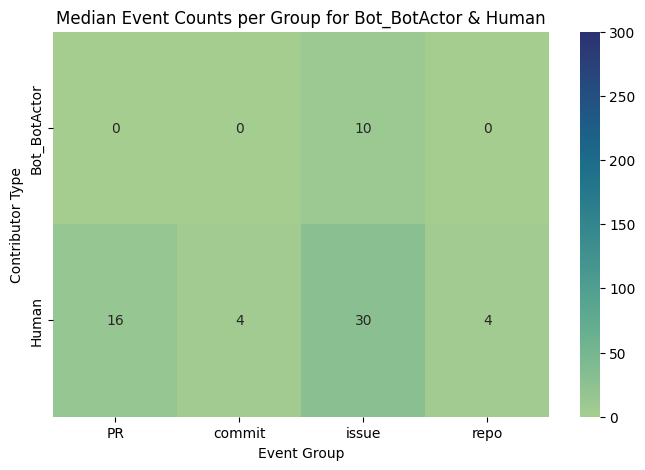

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the median event counts DataFrame
df_medians = pd.read_csv("median_event_counts.csv")

# Pivot the DataFrame to get event groups as columns and acc_type as rows
df_pivot = df_medians.pivot(index="acc_type", columns="event_group", values="median")

# Plot the heatmap using seaborn
plt.figure(figsize=(8, 5))
sns.heatmap(df_pivot, annot=True, vmin=0, vmax=300, cmap="crest")

# Title and labels
plt.title("Median Event Counts per Group for Bot_BotActor & Human")
plt.xlabel("Event Group")
plt.ylabel("Contributor Type")

# Show the plot
plt.show()


#### What is the difference that you observe between Bots+Bot actors and Humans?

In [32]:
Bots and bot actors handle repetitive and automated tasks, especially in commits and pull requests, where they manage CI/CD automation, dependency updates, and code formatting. They are highly active in commit events due to automated merges and updates and frequently participate in pull requests for reviewing and merging code, but they engage less in issue discussions and repository management. Humans, on the other hand, contribute more diverse and meaningful activities, such as discussing issues, reviewing code, and managing repository-level tasks like creating forks and releases. While bots are event-driven—triggered by new PRs, scheduled tasks, or CI/CD pipelines—humans act based on need, whether fixing bugs, reviewing code, or discussing new features. Essentially, bots ensure efficiency by handling routine tasks, while humans focus on decision-making and collaboration, shaping the quality and direction of the project

SyntaxError: invalid character '—' (U+2014) (574657168.py, line 1)

#### What is the differnce that you observe between Event groups?

In [ ]:
Bots are most active in commits and pull requests, handling automated tasks like CI/CD processes, dependency updates, and merges, while humans contribute PRs and commits less frequently but with more meaningful changes. Issue discussions and repository events are largely driven by humans, as bots rarely participate beyond automated labeling or release tagging. In commit events, bots focus on automation, while humans work on feature development and bug fixes. Pull requests see bots handling code formatting and test checks, whereas humans provide detailed reviews and discussions. Similarly, bots automate repository management tasks like tagging releases, while humans manually create forks and manage members, playing a more hands-on role in shaping the project.

#### What is the difference that you observe between Bots+Bot actors and Humans and Event groups all considering at the same time?

In [ ]:
Bots and bot actors are highly active in commits and pull requests, where they handle automated tasks like CI/CD, dependency updates, and code formatting, while humans contribute less frequently but focus on meaningful changes like bug fixes and feature development. In issue-related events, humans dominate, engaging in discussions, reporting bugs, and reviewing code, whereas bots only perform minor automation like labeling issues. Repository events show a mix of both, with bots managing automated releases and tagging versions, while humans manually create forks and manage repository settings. Overall, bots thrive in automation-heavy tasks, ensuring efficiency, while humans contribute critical decision-making and collaboration across different event groups

### Question 3

#### Create boxen plots to visualise the distribution of number of events in each event group. 
#### For more information you can visit - https://seaborn.pydata.org/generated/seaborn.boxenplot.html#seaborn.boxenplot 
#### You should highlight the data points that correspond to bots using a stripplot in seaborn. https://seaborn.pydata.org/tutorial/categorical.html#categorical-tutorial  
#### Interpret the results of the visualisation.

/tmp/ipykernel_7679/1147498231.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(x="acc_type", y="PR", data=df, palette="pastel")


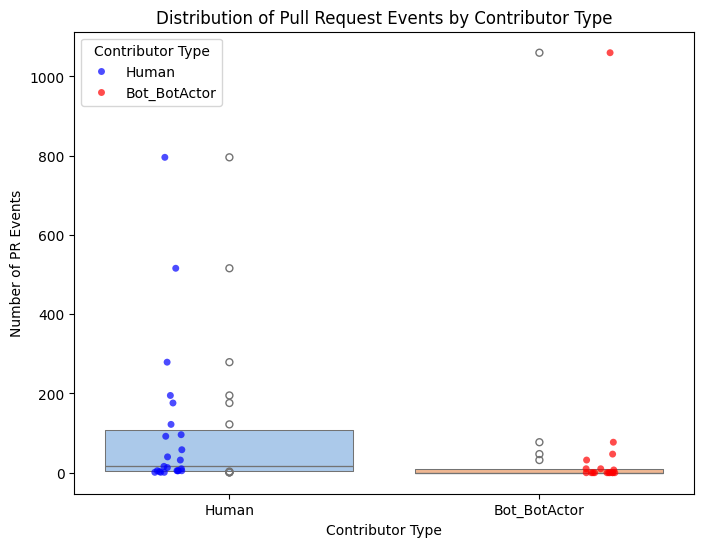

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset containing event counts and acc_type
df = pd.read_csv("final_event_counts.csv")

# Ensure acc_type column uses consistent labels
df["acc_type"] = df["acc_type"].replace({"Bot": "Bot_BotActor"})  # Standardizing the labels if needed

# Define the figure size
plt.figure(figsize=(8, 6))

# Create the boxen plot for Pull Request (PR) events
sns.boxenplot(x="acc_type", y="PR", data=df, palette="pastel")

# Fix: Ensure all acc_type values are covered in the palette
palette = {"Bot_BotActor": "red", "Human": "blue"}

# Overlay stripplot to highlight bot-related data points
sns.stripplot(x="acc_type", y="PR", data=df, hue="acc_type", 
              jitter=True, dodge=True, marker="o", alpha=0.7, palette=palette)

# Labels and title
plt.xlabel("Contributor Type")
plt.ylabel("Number of PR Events")
plt.title("Distribution of Pull Request Events by Contributor Type")
plt.legend(title="Contributor Type")

# Show the plot
plt.show()


/tmp/ipykernel_7679/1506573722.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(x="acc_type", y=event, data=df, palette="pastel")


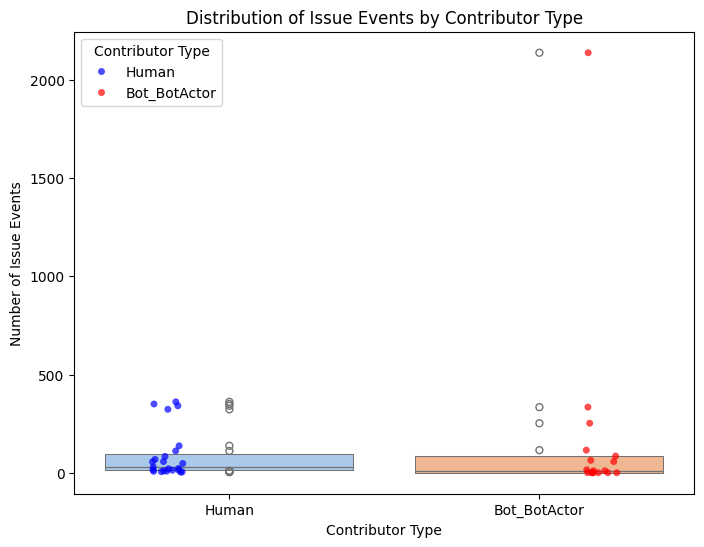

/tmp/ipykernel_7679/1506573722.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(x="acc_type", y=event, data=df, palette="pastel")


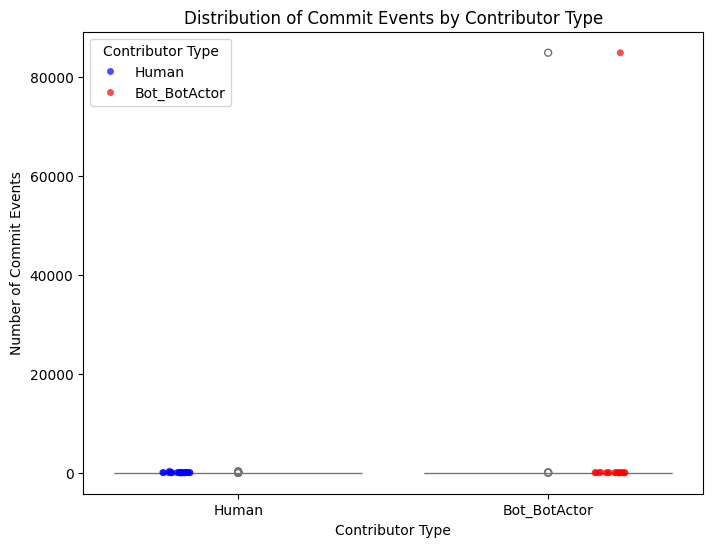

/tmp/ipykernel_7679/1506573722.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(x="acc_type", y=event, data=df, palette="pastel")


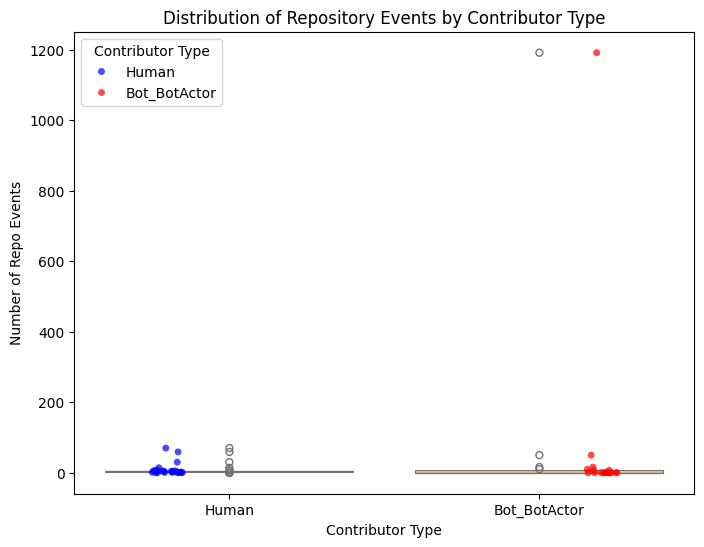

In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset containing event counts and acc_type
df = pd.read_csv("final_event_counts.csv")

# Ensure acc_type column uses consistent labels
df["acc_type"] = df["acc_type"].replace({"Bot": "Bot_BotActor"})  # Standardizing the labels if needed

# Define event types to plot
event_types = ["issue", "commit", "repo"]
titles = {
    "issue": "Distribution of Issue Events by Contributor Type",
    "commit": "Distribution of Commit Events by Contributor Type",
    "repo": "Distribution of Repository Events by Contributor Type"
}

# Define a consistent color palette
palette = {"Bot_BotActor": "red", "Human": "blue"}

# Loop through each event type and create plots
for event in event_types:
    plt.figure(figsize=(8, 6))

    # Create the boxen plot
    sns.boxenplot(x="acc_type", y=event, data=df, palette="pastel")

    # Overlay stripplot to highlight bot-related data points
    sns.stripplot(x="acc_type", y=event, data=df, hue="acc_type", 
                  jitter=True, dodge=True, marker="o", alpha=0.7, palette=palette)

    # Labels and title
    plt.xlabel("Contributor Type")
    plt.ylabel(f"Number of {event.capitalize()} Events")
    plt.title(titles[event])
    plt.legend(title="Contributor Type")

    # Show the plot
    plt.show()


### Question 4.1

#### Statistical identify whether number of events in each event group is normally distributed or not.
#### Null hypothesis - $H_0$: Sample comes from the data that has normal distribution.
#### Use Shapiro-Wilk test for this purpose. Use the p-value with a threshold of 0.05 to determine whether $H_0$ can be rejected with statistical significance or not. 

#### Use shapiro from scipy.stats to perform this test (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html)

In [35]:
import pandas as pd
from scipy.stats import shapiro

# Load the dataset containing event counts
df = pd.read_csv("final_event_counts.csv")

# Define event groups to test
event_groups = ["PR", "commit", "issue", "repo"]

# Perform the Shapiro-Wilk test for each event group
normality_results = {}
for group in event_groups:
    stat, p_value = shapiro(df[group])  # Perform the test
    normality_results[group] = {"Shapiro-Wilk Statistic": stat, "p-value": p_value}

    # Print results
    print(f"Shapiro-Wilk Test for {group}:")
    print(f"  - Test Statistic: {stat:.4f}")
    print(f"  - p-value: {p_value:.4f}")

    # Interpretation
    if p_value < 0.05:
        print(f"  - Conclusion: Reject H_0 (Data is NOT normally distributed)\n")
    else:
        print(f"  - Conclusion: Fail to reject H_0 (Data is normally distributed)\n")

# Convert results to a DataFrame for easy visualization
df_shapiro = pd.DataFrame.from_dict(normality_results, orient="index")
df_shapiro.to_csv("shapiro_results.csv", index=True)

# Display the DataFrame
print(df_shapiro)


Shapiro-Wilk Test for PR:
  - Test Statistic: 0.0704
  - p-value: 0.0000
  - Conclusion: Reject H_0 (Data is NOT normally distributed)

Shapiro-Wilk Test for commit:
  - Test Statistic: 0.0016
  - p-value: 0.0000
  - Conclusion: Reject H_0 (Data is NOT normally distributed)

Shapiro-Wilk Test for issue:
  - Test Statistic: 0.0345
  - p-value: 0.0000
  - Conclusion: Reject H_0 (Data is NOT normally distributed)

Shapiro-Wilk Test for repo:
  - Test Statistic: 0.0166
  - p-value: 0.0000
  - Conclusion: Reject H_0 (Data is NOT normally distributed)

        Shapiro-Wilk Statistic        p-value
PR                    0.070355  1.608880e-136
commit                0.001639  1.245403e-138
issue                 0.034467  1.222277e-137
repo                  0.016580  3.492043e-138


/home/codespace/.local/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 21957.
  res = hypotest_fun_out(*samples, **kwds)


### Question 4.2
#### Determine if there is any statistical diﬀerence in number of events between the identified event groups. Perform this test on all pairs of event groups. 
#### Null hypothesis - $H_0$: Any two event group come from the same population.
#### If $H_0$ is rejected in Shapiro-Wilk test (at least for one of the two event groups considered for test), use the Mann-Whitney U statistical test for this purpose. If $H_0$ is not rejected in Shapiro-Wilk test, use the independent t-test for this purpose.  
#### In any case, use the p-value with a threshold of 0.01 to determine whether $H_0$ can be rejected with statistical significance. 

#### Use mannwhitneyu from scipy.stats to perform Mann-Whitney U test (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html) 
#### or 
#### ttest_ind from scipy.stats to perform independent t-test https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html.

#### More information:

You can pass the following arguments to mannwhitneyu from scipy.stats - (method='exact', nan_policy='omit'). For ttest_ind you can use - (nan_policy='omit')

In [36]:
import pandas as pd
from scipy.stats import shapiro, mannwhitneyu, ttest_ind
from itertools import combinations

# Load the dataset containing event counts
df = pd.read_csv("final_event_counts.csv")

# Define event groups
event_groups = ["PR", "commit", "issue", "repo"]

# Perform the Shapiro-Wilk normality test for each event group
normality_results = {}
for group in event_groups:
    stat, p_value = shapiro(df[group])
    normality_results[group] = (stat, p_value)

# Function to determine if data is normally distributed
def is_normal(group):
    return normality_results[group][1] >= 0.05  # Fail to reject H0 → normal distribution

# Perform statistical comparisons for all pairs of event groups
test_results = []
for group1, group2 in combinations(event_groups, 2):
    # Check normality for both groups
    normal1 = is_normal(group1)
    normal2 = is_normal(group2)

    # Choose statistical test based on normality
    if normal1 and normal2:
        stat, p_value = ttest_ind(df[group1], df[group2])  # Use t-test
        test_type = "t-test"
    else:
        stat, p_value = mannwhitneyu(df[group1], df[group2], alternative="two-sided")  # Use Mann-Whitney U
        test_type = "Mann-Whitney U"

    # Interpret results
    significance = "Reject H_0 (Significant Difference)" if p_value < 0.01 else "Fail to Reject H_0 (No Significant Difference)"

    # Store results
    test_results.append({
        "Group 1": group1,
        "Group 2": group2,
        "Test Used": test_type,
        "Test Statistic": stat,
        "p-value": p_value,
        "Conclusion": significance
    })

# Convert results into a DataFrame for better readability
df_test_results = pd.DataFrame(test_results)

# Save results to CSV
df_test_results.to_csv("event_group_comparisons.csv", index=False)

# Display results
print(df_test_results)


  Group 1 Group 2       Test Used  Test Statistic        p-value  \
0      PR  commit  Mann-Whitney U     257952232.5  1.342037e-176   
1      PR   issue  Mann-Whitney U     187810967.0   0.000000e+00   
2      PR    repo  Mann-Whitney U     100347184.5   0.000000e+00   
3  commit   issue  Mann-Whitney U     170803283.0   0.000000e+00   
4  commit    repo  Mann-Whitney U      77987888.0   0.000000e+00   
5   issue    repo  Mann-Whitney U     172037096.5   0.000000e+00   

                            Conclusion  
0  Reject H_0 (Significant Difference)  
1  Reject H_0 (Significant Difference)  
2  Reject H_0 (Significant Difference)  
3  Reject H_0 (Significant Difference)  
4  Reject H_0 (Significant Difference)  
5  Reject H_0 (Significant Difference)  


/home/codespace/.local/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 21957.
  res = hypotest_fun_out(*samples, **kwds)


### Question 4.3
#### Each time you reject the null hypothesis $H_0$, quantify the effect size of the diﬀerence between the groups using cliﬀ’s delta ($\delta$). 
#### To calculate cliﬀ’s delta, you can pass the list of values to cliﬀ delta.py file given in the repository. E.g., cliffsDelta.cliffsDelta(list of values, list of values). This will return the effect size.
#### Refer to the table given in the TP document and mention your interpretation (negligible, small, medium, large).

In [37]:
import pandas as pd
import cliffsDelta  # Ensure cliff_delta.py is available in the repository

# Load statistical test results
df_test_results = pd.read_csv("event_group_comparisons.csv")

# Load the event counts dataset
df_events = pd.read_csv("final_event_counts.csv")

# Interpretation table for Cliff's Delta
cliffs_delta_interpretation = {
    (0, 0.147): "Negligible",
    (0.147, 0.33): "Small",
    (0.33, 0.474): "Medium",
    (0.474, 1): "Large"
}

# Function to interpret Cliff’s Delta effect size
def interpret_cliffs_delta(delta):
    for (low, high), label in cliffs_delta_interpretation.items():
        if low <= abs(delta) < high:
            return label
    return "Unknown"

# Compute Cliff’s Delta for pairs where H_0 was rejected
cliffs_results = []
for _, row in df_test_results.iterrows():
    if "Reject H_0" in row["Conclusion"]:  # Only for significant differences
        group1, group2 = row["Group 1"], row["Group 2"]
        
        # Extract values for the two groups
        values1 = df_events[group1].tolist()
        values2 = df_events[group2].tolist()
        
        # Compute Cliff's Delta (Fix: Do not unpack)
        delta = cliffsDelta.cliffsDelta(values1, values2)
        
        # Interpret effect size
        effect_size_label = interpret_cliffs_delta(delta)
        
        # Store results
        cliffs_results.append({
            "Group 1": group1,
            "Group 2": group2,
            "Cliff’s Delta": delta,
            "Effect Size": effect_size_label
        })

# Convert results into a DataFrame
df_cliffs_results = pd.DataFrame(cliffs_results)

# Save to CSV
df_cliffs_results.to_csv("cliffs_delta_results.csv", index=False)

# Display results
print(df_cliffs_results)


  Group 1 Group 2  Cliff’s Delta Effect Size
0      PR  commit       0.070097  Negligible
1      PR   issue      -0.220879       Small
2      PR    repo      -0.583717       Large
3  commit   issue      -0.291434       Small
4  commit    repo      -0.676473       Large
5   issue    repo      -0.286316       Small
